In [878]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hanaa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hanaa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [879]:
# Load training dataset
train_df = pd.read_csv('train.csv')

In [880]:
train_df.shape

(770, 2)

In [881]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 770 entries, 0 to 769
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweets  599 non-null    object
 1   label   599 non-null    object
dtypes: object(2)
memory usage: 12.2+ KB


In [882]:
train_df.isna().sum()
# Checking for null values

Tweets    171
label     171
dtype: int64

In [883]:
train_df = train_df.dropna()
# Drop all rows containing null values

In [884]:
train_df.shape

(599, 2)

In [885]:
train_df.isna().sum()
# No more null values in dataset

Tweets    0
label     0
dtype: int64

In [886]:
train_df.head()

,Tweets,label
0,Asked #ChatGPT about what it thinks are the pr...,Positive
1,#ChatGPT tornado has already traveled around t...,Neutral
2,This is a great explanation of why #EVs are mo...,Positive
3,‘if you need to write a box-ticking social med...,Positive
4,Just saw an AI tool making my coffee for me. \...,Positive


In [887]:
train_df.label.value_counts()

Positive    378
Negative    143
Neutral      78
Name: label, dtype: int64

In [888]:
train_df.label = train_df.label.map({'Positive':2, 'Neutral':1, 'Negative':0})
# Mapping each label to a numerical value

In [889]:
train_df.head()

,Tweets,label
0,Asked #ChatGPT about what it thinks are the pr...,2
1,#ChatGPT tornado has already traveled around t...,1
2,This is a great explanation of why #EVs are mo...,2
3,‘if you need to write a box-ticking social med...,2
4,Just saw an AI tool making my coffee for me. \...,2


In [890]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 599 entries, 0 to 598
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweets  599 non-null    object
 1   label   599 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 14.0+ KB


In [891]:
train_df['Tweets'][26]

'Is there anything #chatgpt cannot do? 😂 https://t.co/OqkWEbSkAT'

In [892]:
# Initialize stopwords and lemmatizer
stop = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [893]:
# Define a funciton to perform NLP tasks
def text_to_words(raw_text):
    url = re.compile('https?://\S+|www\.\S+')
    url = url.sub(r' ',raw_text)
    letters_only = re.sub('[^a-zA-Z]',' ', url)
    words = letters_only.lower().split()
    no_stopwords = [word for word in words if not word in stop] 
    lemmatized = [lemmatizer.lemmatize(word) for word in no_stopwords]
    return ' '.join(lemmatized)

In [894]:
# Get clean form of tweets 
train_df['clean'] = train_df['Tweets'].apply(text_to_words)

In [895]:
train_df.head()

,Tweets,label,clean
0,Asked #ChatGPT about what it thinks are the pr...,2,asked chatgpt think problem associated urbanis...
1,#ChatGPT tornado has already traveled around t...,1,chatgpt tornado already traveled around world ...
2,This is a great explanation of why #EVs are mo...,2,great explanation ev efficient energy source c...
3,‘if you need to write a box-ticking social med...,2,need write box ticking social medium post usin...
4,Just saw an AI tool making my coffee for me. \...,2,saw ai tool making coffee chatgpt ai aimagic


In [896]:
train_df['clean'][26]

'anything chatgpt cannot'

In [897]:
# Separate dataset based on labels to generate Word Clouds
pos = train_df[train_df['label']==2]
neu = train_df[train_df['label']==1]
neg = train_df[train_df['label']==0]

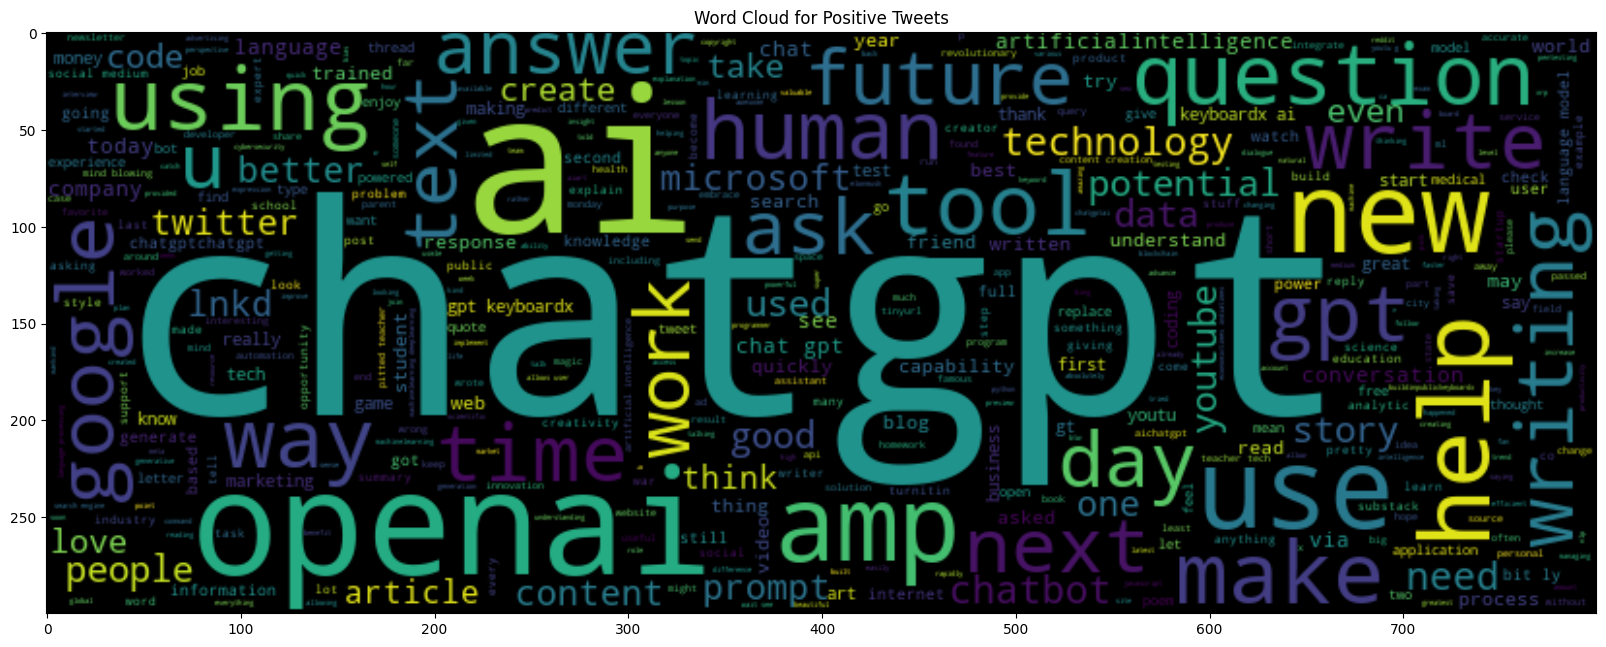

In [898]:
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=500, width=800, height=300).generate(''.join(pos.clean))
plt.imshow(wc, interpolation='bilinear')
plt.title('Word Cloud for Positive Tweets')
plt.show()

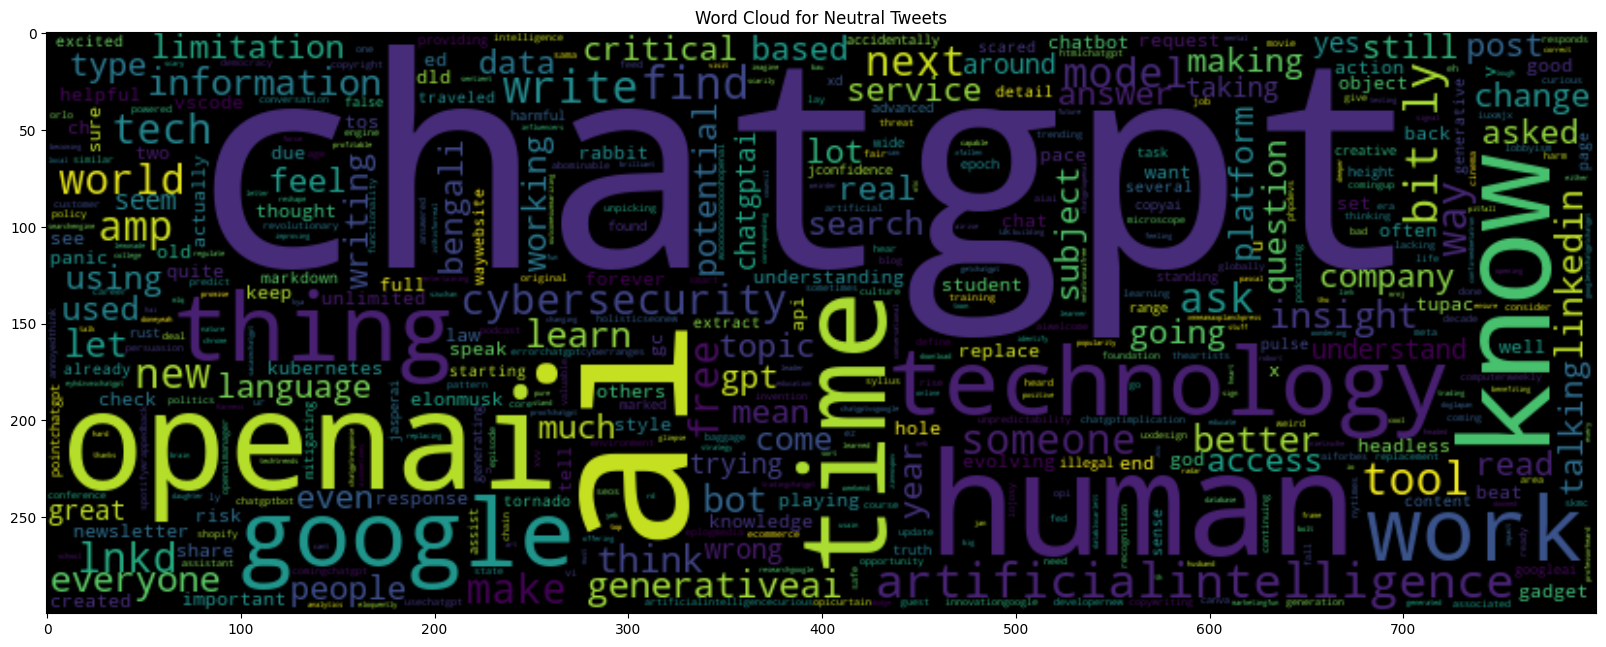

In [899]:
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=500, width=800, height=300).generate(''.join(neu.clean))
plt.imshow(wc, interpolation='bilinear')
plt.title('Word Cloud for Neutral Tweets')
plt.show()

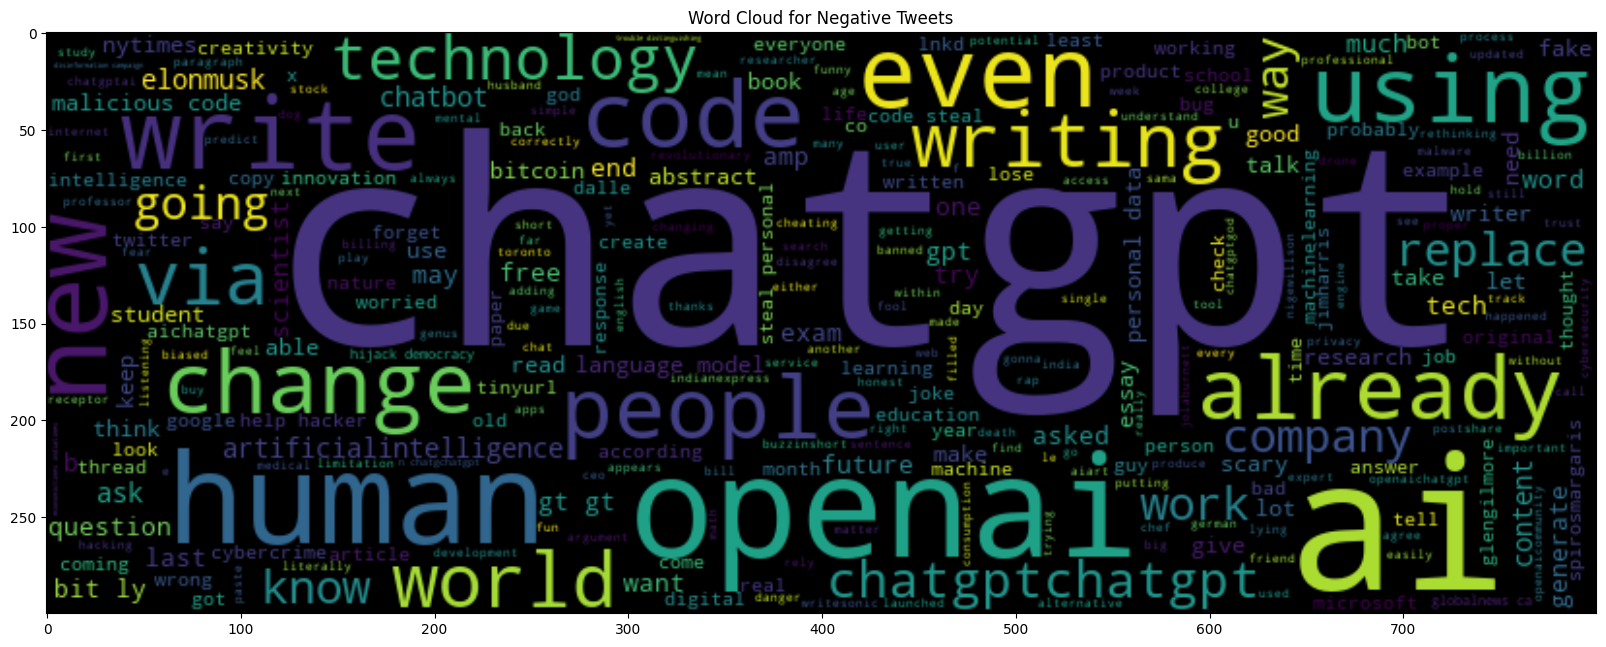

In [900]:
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=500, width=800, height=300).generate(''.join(neg.clean))
plt.imshow(wc, interpolation='bilinear')
plt.title('Word Cloud for Negative Tweets')
plt.show()

In [901]:
X = train_df.clean
y = train_df.label

In [902]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

In [903]:
tokeniser = tf.keras.preprocessing.text.Tokenizer()
tokeniser.fit_on_texts(X_train)
X_train = tokeniser.texts_to_sequences(X_train)
X_test = tokeniser.texts_to_sequences(X_test)
maxlen=50
vocab_size = len(tokeniser.word_index)+1
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen, padding='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen, padding='post')

In [904]:
def getGloveembeddings(glove_folder):
    embedding_dict = dict()
    glove_file = open(f"{glove_folder}glove.6B.50D.txt", encoding='utf8')
    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dims = np.asarray(records[1:], dtype='float32')
        embedding_dict[word]=vector_dims
    glove_file.close()
    return embedding_dict

In [905]:
glove_folder = "C:/Users/hanaa/Desktop/deep-learning/DLENV/Glove/"
embeddings_dict = getGloveembeddings(glove_folder)
embeddings_matrix = np.zeros((vocab_size, maxlen))
for word, index in tokeniser.word_index.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embeddings_matrix[index] = embedding_vector

In [906]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=maxlen, weights=[embeddings_matrix], input_length=maxlen, trainable=False))
model.add(tf.keras.layers.LSTM(maxlen))
model.add(tf.keras.layers.Dense(24, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

In [907]:
print(model.summary())

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 50, 50)            144500    
                                                                 
 lstm_19 (LSTM)              (None, 50)                20200     
                                                                 
 dense_38 (Dense)            (None, 24)                1224      
                                                                 
 dense_39 (Dense)            (None, 3)                 75        
                                                                 
Total params: 165999 (648.43 KB)
Trainable params: 21499 (83.98 KB)
Non-trainable params: 144500 (564.45 KB)
_________________________________________________________________
None


In [908]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', mode='min',patience=20)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=16 ,validation_split = 0.2, callbacks = [early_stopping])

Epoch 1/50
24/24 [==============================] - 2s 30ms/step - loss: 1.0519 - accuracy: 0.6162 - val_loss: 1.0228 - val_accuracy: 0.5833
Epoch 2/50
24/24 [==============================] - 0s 21ms/step - loss: 0.9122 - accuracy: 0.6423 - val_loss: 1.0051 - val_accuracy: 0.5833
Epoch 3/50
24/24 [==============================] - 0s 16ms/step - loss: 0.8668 - accuracy: 0.6423 - val_loss: 1.0783 - val_accuracy: 0.5833
Epoch 4/50
24/24 [==============================] - 0s 16ms/step - loss: 0.8788 - accuracy: 0.6423 - val_loss: 1.0091 - val_accuracy: 0.5833
Epoch 5/50
24/24 [==============================] - 0s 17ms/step - loss: 0.8596 - accuracy: 0.6423 - val_loss: 1.0004 - val_accuracy: 0.5833
Epoch 6/50
24/24 [==============================] - 0s 21ms/step - loss: 0.8358 - accuracy: 0.6475 - val_loss: 1.0567 - val_accuracy: 0.5833
Epoch 7/50
24/24 [==============================] - 0s 16ms/step - loss: 0.8108 - accuracy: 0.6606 - val_loss: 1.0334 - val_accuracy: 0.5833
Epoch 8/50
24

In [909]:
y_preds = model.predict(X_test)

4/4 [==============================] - 0s 5ms/step


In [910]:
preds=[]
for row in y_preds:
    pred = np.argmax(row)
    preds.append(pred)

In [911]:
y_test

116    1
53     1
524    2
540    2
351    2
      ..
569    0
17     2
109    0
249    2
370    2
Name: label, Length: 120, dtype: int64

In [912]:
acc = accuracy_score(y_test, preds)
print('Accuracy: %.2f' %acc)

Accuracy: 0.62


In [913]:
test_df=pd.read_csv('test.csv', names=['Tweets','label'])

In [914]:
test_df.head()

,Tweets,label
0,@CoffeeVectors @jenny____r confirmed #ChatGPT ...,Positive
1,Sooooo depressing (our competition as journos ...,Negative
2,I just had a 4 hour deep conversation with #Ch...,Positive
3,I began to explore #chatgpt today.\n\nI asked ...,Negative
4,/2023\n1. Ask #ChatGPT\n2. Add some content\n3...,Positive


In [915]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweets  171 non-null    object
 1   label   171 non-null    object
dtypes: object(2)
memory usage: 2.8+ KB


In [916]:
test_df.isna().sum()

Tweets    0
label     0
dtype: int64

In [917]:
test_df['label'].value_counts()

Positive    115
Negative     37
Neutral      19
Name: label, dtype: int64

In [918]:
test_df.label = test_df.label.map({'Positive':2, 'Neutral':1, 'Negative':0})

In [919]:
test_df.head()

,Tweets,label
0,@CoffeeVectors @jenny____r confirmed #ChatGPT ...,2
1,Sooooo depressing (our competition as journos ...,0
2,I just had a 4 hour deep conversation with #Ch...,2
3,I began to explore #chatgpt today.\n\nI asked ...,0
4,/2023\n1. Ask #ChatGPT\n2. Add some content\n3...,2


In [920]:
test_df['label'].value_counts()

2    115
0     37
1     19
Name: label, dtype: int64

In [921]:
test_df['clean'] = test_df['Tweets'].apply(text_to_words)
test_df.head()

,Tweets,label,clean
0,@CoffeeVectors @jenny____r confirmed #ChatGPT ...,2,coffeevectors jenny r confirmed chatgpt dad joke
1,Sooooo depressing (our competition as journos ...,0,sooooo depressing competition journos writer s...
2,I just had a 4 hour deep conversation with #Ch...,2,hour deep conversation chatgpt future wild kno...
3,I began to explore #chatgpt today.\n\nI asked ...,0,began explore chatgpt today asked bio found ma...
4,/2023\n1. Ask #ChatGPT\n2. Add some content\n3...,2,ask chatgpt add content publish


In [922]:
test = test_df.clean

In [923]:
test = tokeniser.texts_to_sequences(test)
test = tf.keras.preprocessing.sequence.pad_sequences(test, maxlen=maxlen, padding='post')

In [924]:
tpreds = model.predict(test)

6/6 [==============================] - 0s 9ms/step


In [925]:
test_preds=[]
for row in tpreds:
    pred = np.argmax(row)
    test_preds.append(pred)

In [926]:
acc = accuracy_score(test_df.label, test_preds)
print('Test Accuracy: %.2f' %acc)

Test Accuracy: 0.71
